In [1]:
!pip install tqdm

In [1]:
!conda install -y tqdm

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.23.3                |           py36_0          58 KB
    conda-4.5.4                |           py36_0         1.0 MB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

    tqdm:  4.23.3-py36_0

The following packages will be UPDATED:

    conda: 4.5.2-py36_0  --> 4.5.4-py36_0


tqdm 4.23.3############################################################# | 100% 
conda 4.5.4############################################################# | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import tqdm
import numpy as np

In [2]:
from pfm_utils import readPFM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--lr', '--learning-rate', default=2e-4, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum for sgd, alpha parameter for adam')
parser.add_argument('--beta', default=0.999, type=float, metavar='M',
                    help='beta parameters for adam')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay')
parser.add_argument('--epochs', default=60, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=6, type=int,
                    metavar='N', help='mini-batch size')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers')

args = parser.parse_args(["--lr", "0.01", "-b", "6"])

In [5]:
#FIXME add loading from weights
# weights = torch.load('dispnet_model_best.pth.tar')
# disp_net.load_state_dict(weights['state_dict'])

In [6]:
import torchvision

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, left_img, right_img, disp_map):
        for t in self.transforms:
            left_img, right_img, disp_map = t(left_img, right_img, disp_map)
        return left_img, right_img, disp_map


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, left_img, right_img, disp_map):
        for tensor in [left_img, right_img]:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.sub_(m).div_(s)
        return left_img, right_img, disp_map
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, left_img, right_img, disp_map):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        left_img = torch.from_numpy(left_img.transpose((2, 0, 1)))
        right_img = torch.from_numpy(right_img.transpose((2, 0, 1)))
        disp_map = torch.from_numpy(disp_map.copy())
       
        return left_img, right_img, disp_map
    


train_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
import numpy as np
import torch
from os.path import join
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time

%matplotlib inline

In [8]:
from DispNet_QR_G import DispNet
disp_net = DispNet()
disp_net.init_weights()
disp_net.cuda()

/home/safin/DispNet/DispNet_QR_G.py:106: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


DispNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv3a): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv3b): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv4a): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512,

In [9]:
def get_segment(value, step = 30, n_segments = 10):
    segment_num = value.long()/step
    segment_num = segment_num.where(segment_num<n_segments, torch.LongTensor([n_segments-1]))
    offset = value - (segment_num*step).float()
    return segment_num, offset

In [10]:
import numpy as np

train_fnames = np.load('fnames/train_fnames.npy')
test_fnames = np.load('fnames/test_fnames.npy')
val_fnames = np.load('fnames/val_fnames.npy')

In [11]:
from data_loader import SequenceFolder

#3600 objects
train_set = SequenceFolder(train_fnames, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True) #pin_memory=False

#100 objects
val_set = SequenceFolder(val_fnames, transform=train_transform)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=True,
    num_workers=args.workers, pin_memory=True)

In [12]:
N_train = len(train_set)
N_val = len(val_set)

test_set = SequenceFolder(test_fnames, transform=train_transform)
left_ref_img, right_ref_img, _ = test_set[0]
left_ref_img=left_ref_img.unsqueeze(0)
right_ref_img=right_ref_img.unsqueeze(0)

In [13]:
def shift_weights(weights):
    return weights[1:]+[weights[0]]

In [14]:
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import time

logdir = 'logs-qr/'

loss_func = nn.MSELoss()
logloss_func = nn.CrossEntropyLoss()
train_loss = []
val_loss = []
step = 30

regr_weight = 0.1
class_weight = 1000

weights = [0, 0, 0, 0, 0, 0.9, 0.1, 0] #0.9, 0.09, 0.01

for i, n_epochs in enumerate([20, 20, 15, 15, 15, 25]):
    print("curr_iter:", i)
    parameters = disp_net.parameters()
    optimizer = torch.optim.Adam(parameters, args.lr,
                             betas=(args.momentum, args.beta),
                             weight_decay=args.weight_decay)
    logfile = logdir+'log_' + str(i)
    w1, w2, w3, w4, w5, w6 = weights[:6]
    print((w1, w2, w3, w4, w5, w6))
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    for j, epoch in enumerate(range(n_epochs)):#range(args.epochs):
        disp_net.train()
        start_time = time.time()
        for left_img, right_img, disp_map in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            X_batch = Variable(torch.cat((left_img, right_img), 1).float())

            disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
            y_batch1 = Variable(disp_map1)
            y_batch2 = Variable(disp_map2)
            y_batch3 = Variable(disp_map3)
            y_batch4 = Variable(disp_map4)
            y_batch5 = Variable(disp_map5)
            y_batch6 = Variable(disp_map6)

            #[1, 6, 540, 920]

            segments1, offsets1 = get_segment(y_batch1.unsqueeze_(1)) 
            segments2, offsets2 = get_segment(y_batch2.unsqueeze_(1)) 
            segments3, offsets3 = get_segment(y_batch3.unsqueeze_(1)) 
            segments4, offsets4 = get_segment(y_batch4.unsqueeze_(1)) 
            segments5, offsets5 = get_segment(y_batch5.unsqueeze_(1)) 
            segments6, offsets6 = get_segment(y_batch6.unsqueeze_(1)) 


            segments_pred1, offsets_pred1, segments_pred2, offsets_pred2, segments_pred3, offsets_pred3,segments_pred4, offsets_pred4,segments_pred5, offsets_pred5,segments_pred6, offsets_pred6  = disp_net(X_batch.cuda())

            offsets_pred1 = offsets_pred1.gather(1, segments1.cuda())
            offsets_pred2 = offsets_pred2.gather(1, segments2.cuda())
            offsets_pred3 = offsets_pred3.gather(1, segments3.cuda())
            offsets_pred4 = offsets_pred4.gather(1, segments4.cuda())
            offsets_pred5 = offsets_pred5.gather(1, segments5.cuda())                    
            offsets_pred6 = offsets_pred6.gather(1, segments6.cuda())

            
            
            pred_1 = segments_pred1.argmax(1, keepdim=True).float()*30+offsets_pred1
            loss_1_1 = logloss_func(segments_pred1.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments1.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_1_2 = loss_func(offsets_pred1, offsets1.cuda())
            loss_1 = 100000*loss_1_1 + 0.1*loss_1_2


            pred_2 = segments_pred2.argmax(1, keepdim=True).float()*30+offsets_pred2
            loss_2_1 = logloss_func(segments_pred2.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments2.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_2_2 = loss_func(offsets_pred2, offsets2.cuda())
            loss_2 = 100000*loss_2_1 + 0.1*loss_2_2


            pred_3 = segments_pred3.argmax(1, keepdim=True).float()*30+offsets_pred3
            loss_3_1 = logloss_func(segments_pred3.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments3.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_3_2 = loss_func(offsets_pred3, offsets3.cuda())
            loss_3 = 100000*loss_3_1 + 0.1*loss_3_2


            pred_4 = segments_pred4.argmax(1, keepdim=True).float()*30+offsets_pred4
            loss_4_1= logloss_func(segments_pred4.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments4.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_4_2 = loss_func(offsets_pred4, offsets4.cuda())
            loss_4 = 100000*loss_4_1 + 0.1*loss_4_2


            pred_5 = segments_pred5.argmax(1, keepdim=True).float()*30+offsets_pred5
            loss_5_1= logloss_func(segments_pred5.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments5.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_5_2 = loss_func(offsets_pred5, offsets5.cuda())
            loss_5 = 100000*loss_5_1 + 0.1*loss_5_2


            pred_6 = segments_pred6.argmax(1, keepdim=True).float()*30+offsets_pred6
            loss_6_1=logloss_func(segments_pred6.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments6.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
            loss_6_2 = loss_func(offsets_pred6, offsets6.cuda())
            loss_6 = 100000*loss_6_1 + 0.1*loss_6_2


            loss=w1*loss_1+w2*loss_2+w3*loss_3+w4*loss_4+w5*loss_5+w6*loss_6
            train_loss.append(np.asscalar(loss.data.cpu().numpy()))
            loss.backward()
            optimizer.step()
            
            
        print("Loss 6 class:", loss_6_1)
        print("Loss 6 regr:", loss_6_2)
        torch.cuda.empty_cache()        
        # reference image
        X_batch = Variable(torch.cat((left_ref_img, right_ref_img), 1).float())            
        disp1, disp2, disp3, disp4, disp5, disp6 = disp_net(X_batch.cuda())
        torch.save((disp1, disp2, disp3, disp4, disp5, disp6), logdir+'ref_imgs/'+str(i)+'_'+str(j))
        optimizer.zero_grad()
        

        torch.cuda.empty_cache()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, args.epochs, time.time() - start_time))
        
        curr_train_loss = np.mean(train_loss[-N_train // args.batch_size :])
        train_loss_epoch.append(curr_train_loss)
        print("  training loss (in-iteration): \t{:.6f}".format(curr_train_loss))
        with open(logfile, 'a') as f:
            f.write("Epoch {} of {} took {:.3f}s\n".format(
            epoch + 1, args.epochs, time.time() - start_time))
            f.write("  training loss (in-iteration): \t{:.6f}\n\n".format(curr_train_loss))

        # And a full pass over the validation data:
        # disable dropout / use averages for batch_norm    
        disp_net.eval()
        for left_img, right_img, disp_map in val_loader:
            X_batch = Variable(torch.cat((left_img, right_img), 1).float())
            disp_map0, _, _, _, _, _, _ = disp_map
            y_batch = Variable(disp_map0)
            disp0 = disp_net(X_batch.cuda()) #concatenate on channel
            pred = disp0.squeeze(1)
            loss = loss_func(pred, y_batch.cuda())
            val_loss.append(np.asscalar(loss.data.cpu().numpy()))
        torch.cuda.empty_cache()
        
        curr_val_loss = np.mean(val_loss[-N_val // 1 :])
        val_loss_epoch.append(curr_val_loss)
        print("  validation loss: \t\t\t{:.6f}".format(curr_val_loss))
        with open(logdir+logfile, 'a') as f:
            f.write("  validation loss: \t\t\t{:.6f}".format(curr_val_loss))
    torch.save(disp_net, logdir+"disp_net-"+str(i)+".pth")
    np.save(logdir+'train_loss-'+str(i),train_loss_epoch)
    np.save(logdir+'val_loss-'+str(i),val_loss_epoch)
    weights = shift_weights(weights)
    

  0%|          | 0/600 [00:00<?, ?it/s]

curr_iter: 0
(0, 0, 0, 0, 0, 0.9)


100%|██████████| 600/600 [08:09<00:00,  1.23it/s]


Loss 6 class: tensor(0.5107, device='cuda:0')
Loss 6 regr: tensor(37.8239, device='cuda:0')


ValueError: too many values to unpack (expected 6)

In [94]:
def shift_weights(weights):
    return weights[1:]+[weights[0]]

In [95]:
#!pip3 install torch

In [112]:
###TEST IN JUST ONE IMAGE####

weights = [0.9, 0.1, 0, 0, 0, 0]
w1, w2, w3, w4, w5, w6 = weights

X_batch = Variable(torch.cat((torch.from_numpy(left_img).float(),torch.from_numpy(right_img).float()),-1).float())
print(X_batch.size())

X_batch = X_batch.unsqueeze(0)

print (X_batch.size())
X_batch = torch.transpose(X_batch, 1, 3)
X_batch = torch.transpose(X_batch, 2, 3)
print ('X_batch size:',X_batch.size())

disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
y_batch1 = Variable(torch.from_numpy(disp_map1).float())
y_batch2 = Variable(torch.from_numpy(disp_map2).float())
y_batch3 = Variable(torch.from_numpy(disp_map3).float())
y_batch4 = Variable(torch.from_numpy(disp_map4).float())
y_batch5 = Variable(torch.from_numpy(disp_map5).float())
y_batch6 = Variable(torch.from_numpy(disp_map6).float())
    

#[1, 6, 540, 920]

segments1, offsets1= get_segment(y_batch1.unsqueeze(0)) 
segments1=segments1.unsqueeze(0)

segments2, offsets2= get_segment(y_batch2.unsqueeze(0)) 
segments2=segments2.unsqueeze(0)

segments3, offsets3= get_segment(y_batch3.unsqueeze(0)) 
segments3=segments3.unsqueeze(0)

segments4, offsets4= get_segment(y_batch4.unsqueeze(0)) 
segments4=segments4.unsqueeze(0)

segments5, offsets5= get_segment(y_batch5.unsqueeze(0)) 
segments5=segments5.unsqueeze(0)

segments6, offsets6= get_segment(y_batch6.unsqueeze(0)) 
segments6=segments6.unsqueeze(0)


segments_pred1, offsets_pred1, segments_pred2, offsets_pred2, segments_pred3, offsets_pred3,segments_pred4, offsets_pred4,segments_pred5, offsets_pred5,segments_pred6, offsets_pred6  = disp_net(X_batch)


loss_func = nn.MSELoss()
logloss_func = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

pred_1 = segments_pred1.argmax(1, keepdim=True).float()*30+offsets_pred1.gather(1, segments1)
loss_1_1 = logloss_func(segments_pred1.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments1.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_1_2 = loss_func(offsets_pred1.gather(1, segments1), offsets1.unsqueeze(0))
loss_1 = 100000*loss_1_1 + 0.1*loss_1_2
#         loss = w1*loss_func(disp1.squeeze(1), y_batch1.cuda()) + w2*loss_func(disp2.squeeze(1), y_batch2.cuda()) \
#                 + w3*loss_func(disp3.squeeze(1), y_batch3.cuda()) + w4*loss_func(disp4.squeeze(1), y_batch4.cuda()) \
#                 + w5*loss_func(disp5.squeeze(1), y_batch5.cuda()) + w6*loss_func(disp6.squeeze(1), y_batch6.cuda


pred_2 = segments_pred2.argmax(1, keepdim=True).float()*30+offsets_pred2.gather(1, segments2)
loss_2_1 = logloss_func(segments_pred2.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments2.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_2_2 = loss_func(offsets_pred2.gather(1, segments2), offsets2.unsqueeze(0))
loss_2 = 100000*loss_2_1 + 0.1*loss_2_2


pred_3 = segments_pred3.argmax(1, keepdim=True).float()*30+offsets_pred3.gather(1, segments3)
loss_3_1 = logloss_func(segments_pred3.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments3.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_3_2 = loss_func(offsets_pred3.gather(1, segments3), offsets3.unsqueeze(0))
loss_3 = 100000*loss_3_1 + 0.1*loss_3_2


pred_4 = segments_pred4.argmax(1, keepdim=True).float()*30+offsets_pred4.gather(1, segments4)
loss_4_1= logloss_func(segments_pred4.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments4.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_4_2 = loss_func(offsets_pred4.gather(1, segments4), offsets4.unsqueeze(0))
loss_4 = 100000*loss_4_1 + 0.1*loss_4_2


pred_5 = segments_pred5.argmax(1, keepdim=True).float()*30+offsets_pred5.gather(1, segments5)
loss_5_1= logloss_func(segments_pred5.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments5.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_5_2 = loss_func(offsets_pred5.gather(1, segments5), offsets5.unsqueeze(0))
loss_5 = 100000*loss_5_1 + 0.1*loss_5_2


pred_6 = segments_pred6.argmax(1, keepdim=True).float()*30+offsets_pred6.gather(1, segments6)
loss_6_1=logloss_func(segments_pred6.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments6.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1))
loss_6_2 = loss_func(offsets_pred6.gather(1, segments6), offsets6.unsqueeze(0))
loss_6 = 100000*loss_6_1 + 0.1*loss_6_2

        
loss=w1*loss_1+w2*loss_2+w3*loss_3+w4*loss_4+w5*loss_5+w6*loss_6
train_loss.append(np.asscalar(loss.data.cpu().numpy()))
loss.backward()
optimizer.step()
print(loss_func(pred_1, y_batch1.unsqueeze(0).unsqueeze(0)))
print(loss_func(pred_2, y_batch2.unsqueeze(0).unsqueeze(0)))
print(loss_func(pred_3, y_batch3.unsqueeze(0).unsqueeze(0)))
print(loss_func(pred_4, y_batch4.unsqueeze(0).unsqueeze(0)))
print(loss_func(pred_5, y_batch5.unsqueeze(0).unsqueeze(0)))
print(loss_func(pred_6, y_batch6.unsqueeze(0).unsqueeze(0)))

torch.Size([540, 960, 6])
torch.Size([1, 540, 960, 6])
X_batch size: torch.Size([1, 6, 540, 960])
out_conv1 torch.Size([1, 64, 270, 480])
out_conv2 torch.Size([1, 128, 135, 240])
out_conv3b torch.Size([1, 256, 68, 120])
out_conv4b torch.Size([1, 512, 34, 60])
out_conv5b torch.Size([1, 512, 17, 30])
out_conv6b torch.Size([1, 1024, 9, 15])
pr6_shifts torch.Size([1, 10, 9, 15])
disp6_probs torch.Size([1, 10, 9, 15])
disp6 torch.Size([1, 1, 17, 30])
out_upconv5 torch.Size([1, 512, 18, 30])
pr5_shifts torch.Size([1, 10, 17, 30])
disp5_probs torch.Size([1, 10, 17, 30])
disp5 torch.Size([1, 1, 34, 60])
out_upconv4 torch.Size([1, 256, 34, 60])
pr4_shifts torch.Size([1, 10, 34, 60])
disp4_probs torch.Size([1, 10, 34, 60])
disp4 torch.Size([1, 1, 68, 120])
pr3_shifts torch.Size([1, 10, 68, 120])
disp3_probs torch.Size([1, 10, 68, 120])
disp3 torch.Size([1, 1, 135, 240])
pr2_shifts torch.Size([1, 10, 135, 240])
disp2_probs torch.Size([1, 10, 135, 240])
disp2 torch.Size([1, 1, 270, 480])
pr1_shift

In [41]:
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import time

loss_func = nn.MSELoss()
logloss_func = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

weights = [0.9, 0.1, 0, 0, 0, 0]
# for n_epochs in [20, 30, 30, 50]:
#     print("curr_n_epochs:", n_epochs)
#     weights = shift_weights(weights)
w1, w2, w3, w4, w5, w6 = weights
for epoch in range(60):#range(args.epochs):
    disp_net.train()
    start_time = time.time()
    #for left_img, right_img in tqdm.tqdm(train_loader):
    optimizer.zero_grad()
    X_batch = Variable(torch.cat((torch.from_numpy(left_img).float(),torch.from_numpy(right_img).float()), 1).float())
    disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
    y_batch1 = Variable(torch.from_numpy(disp_map1).float())
    y_batch2 = Variable(torch.from_numpy(disp_map2).float())
    y_batch3 = Variable(torch.from_numpy(disp_map3).float())
    y_batch4 = Variable(torch.from_numpy(disp_map4).float())
    y_batch5 = Variable(torch.from_numpy(disp_map5).float())
    y_batch6 = Variable(torch.from_numpy(disp_map6).float())
    
    segments1, offsets1= get_segment(y_batch1.unsqueeze(0)) 
    segments1=segments1.unsqueeze(0)

    segments2, offsets2= get_segment(y_batch2.unsqueeze(0)) 
    segments2=segments2.unsqueeze(0)

    segments3, offsets3= get_segment(y_batch3.unsqueeze(0)) 
    segments3=segments3.unsqueeze(0)

    segments4, offsets4= get_segment(y_batch4.unsqueeze(0)) 
    segments4=segments4.unsqueeze(0)

    segments5, offsets5= get_segment(y_batch5.unsqueeze(0)) 
    segments5=segments5.unsqueeze(0)

    segments6, offsets6= get_segment(y_batch6.unsqueeze(0)) 
    segments6=segments6.unsqueeze(0)
    
    segments_pred1, offsets_pred1, segments_pred2, offsets_pred2, segments_pred3, offsets_pred3,segments_pred4, offsets_pred4,segments_pred5, offsets_pred5,segments_pred6, offsets_pred6  = disp_net(X_batch.cuda()) #concatenate on channel
    #segments_pred, offsets_pred = disp1
#         print("segments_pred", segments_pred.size())
#         print("offsets_pred", offsets_pred.size())
#         print("segments", segments.size())
#         print("offsets", offsets.size())       

    pred_1 = segments_pred1.argmax(1, keepdim=True).float()*30+offsets_pred1.gather(1, segments1.cuda())
    loss_1_1 = logloss_func(segments_pred1.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments1.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_1_2 = loss_func(offsets_pred1.gather(1, segments1.cuda()), offsets1.unsqueeze(0).cuda())
    loss_1 = 100000*loss_1_1 + 0.1*loss_1_2
#         loss = w1*loss_func(disp1.squeeze(1), y_batch1.cuda()) + w2*loss_func(disp2.squeeze(1), y_batch2.cuda()) \
#                 + w3*loss_func(disp3.squeeze(1), y_batch3.cuda()) + w4*loss_func(disp4.squeeze(1), y_batch4.cuda()) \
#                 + w5*loss_func(disp5.squeeze(1), y_batch5.cuda()) + w6*loss_func(disp6.squeeze(1), y_batch6.cuda


    pred_2 = segments_pred2.argmax(1, keepdim=True).float()*30+offsets_pred2.gather(1, segments2.cuda())
    loss_2_1 = logloss_func(segments_pred2.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments2.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_2_2 = loss_func(offsets_pred2.gather(1, segments2.cuda()), offsets2.unsqueeze(0).cuda())
    loss_2 = 100000*loss_2_1 + 0.1*loss_2_2


    pred_3 = segments_pred3.argmax(1, keepdim=True).float()*30+offsets_pred3.gather(1, segments3.cuda())
    loss_3_1 = logloss_func(segments_pred3.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments3.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_3_2 = loss_func(offsets_pred3.gather(1, segments3.cuda()), offsets3.unsqueeze(0).cuda())
    loss_3 = 100000*loss_3_1 + 0.1*loss_3_2


    pred_4 = segments_pred4.argmax(1, keepdim=True).float()*30+offsets_pred4.gather(1, segments4.cuda())
    loss_4_1= logloss_func(segments_pred4.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments4.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_4_2 = loss_func(offsets_pred4.gather(1, segments4.cuda()), offsets4.unsqueeze(0).cuda())
    loss_4 = 100000*loss_4_1 + 0.1*loss_4_2


    pred_5 = segments_pred5.argmax(1, keepdim=True).float()*30+offsets_pred5.gather(1, segments5.cuda())
    loss_5_1= logloss_func(segments_pred5.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments5.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_5_2 = loss_func(offsets_pred5.gather(1, segments5.cuda()), offsets5.unsqueeze(0).cuda())
    loss_5 = 100000*loss_5_1 + 0.1*loss_5_2


    pred_6 = segments_pred6.argmax(1, keepdim=True).float()*30+offsets_pred6.gather(1, segments6.cuda())
    loss_6_1=logloss_func(segments_pred6.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments6.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda())
    loss_6_2 = loss_func(offsets_pred6.gather(1, segments6.cuda()), offsets6.unsqueeze(0).cuda())
    loss_6 = 100000*loss_6_1 + 0.1*loss_6_2

    
    
    loss=w1*loss_1+w2*loss_2+w3*loss_3+w4*loss_4+w5*loss_5+w6*loss_6
    train_loss.append(np.asscalar(loss.data.cpu().numpy()))
    loss.backward()
    optimizer.step()
    print(loss_func(pred_1, y_batch1.cuda()))
    print(loss_func(pred_2, y_batch2.cuda()))
    print(loss_func(pred_3, y_batch3.cuda()))
    print(loss_func(pred_4, y_batch4.cuda()))
    print(loss_func(pred_5, y_batch5.cuda()))
    print(loss_func(pred_6, y_batch6.cuda()))
    torch.cuda.empty_cache()
    torch.save(disp_net,"disp_net-last-qr.pth")
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, args.epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-N_train // args.batch_size :])))
    with open('log', 'a') as f:
        f.write("Epoch {} of {} took {:.3f}s\n".format(
        epoch + 1, args.epochs, time.time() - start_time))
        f.write("  training loss (in-iteration): \t{:.6f}\n\n".format(
        np.mean(train_loss[-N_train // args.batch_size :])))

    # And a full pass over the validation data:
    # disable dropout / use averages for batch_norm    
    disp_net.eval()
    for left_img, right_img, disp_map in val_loader:
        X_batch = Variable(torch.cat((left_img, right_img), 1).float())
        disp_map0, _, _, _, _, _, _ = disp_map
        y_batch = Variable(disp_map0)
        disp0 = disp_net(X_batch.cuda()) #concatenate on channel
        pred = disp0.squeeze(1)
        loss = loss_func(pred, y_batch.cuda())
        val_loss.append(np.asscalar(loss.data.cpu().numpy()))
    torch.cuda.empty_cache()
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-N_val // 1 :])))

SystemError: <built-in function where> returned a result with an error set

In [0]:
torch.save(disp_net,"disp_net-last-qr.pth")

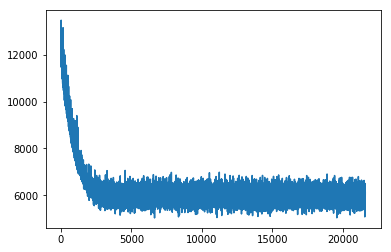

In [0]:
plt.plot(np.asarray(train_loss))

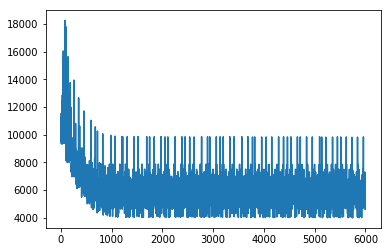

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.asarray(val_loss))

In [0]:
np.save('train_loss-last',train_loss)
np.save('val_loss-last',val_loss)

In [0]:

#700 objects
test_set = SequenceFolder(test_fnames, transform=train_transform)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True)
N_test = len(test_set)

In [0]:
%%time
disp_net.eval()

test_loss = []
for left_img, right_img, disp_map in test_loader:
    X_batch = Variable(torch.cat((left_img, right_img), 1).float())
    disp_map0, _, _, _, _, _, _ = disp_map
    y_batch = Variable(disp_map0)
    disp0 = disp_net(X_batch.cuda()) #concatenate on channel
    pred = disp0.squeeze(1)
    loss = loss_func(pred, y_batch.cuda())
    test_loss.append(np.asscalar(loss.data.cpu().numpy()))

print("  test loss: \t\t\t{:.6f}".format(
    np.mean(test_loss[-N_test // args.batch_size :])))

  test loss: 			89.901345
CPU times: user 2min 14s, sys: 35.8 s, total: 2min 50s
Wall time: 44.9 s


In [0]:
ind = 183
disp_net.eval()
left_img, right_img, disp_map = test_set[ind]
disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp0 = disp_net(X.cuda())

In [0]:
ind = 183
disp_net.train()
left_img, right_img, disp_map = test_set[ind]
disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp0 = disp_net(X.cuda())

In [0]:
np.unique(disp1_probs.argmax(1).data.cpu().numpy())

array([0, 1])

In [0]:
ind = 0
left_img, right_img, disp_map = test_set[ind]
disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp1, disp2, disp3, disp4, disp5, disp6  = disp_net(X.cuda())

Text(0.5,1,'Right')

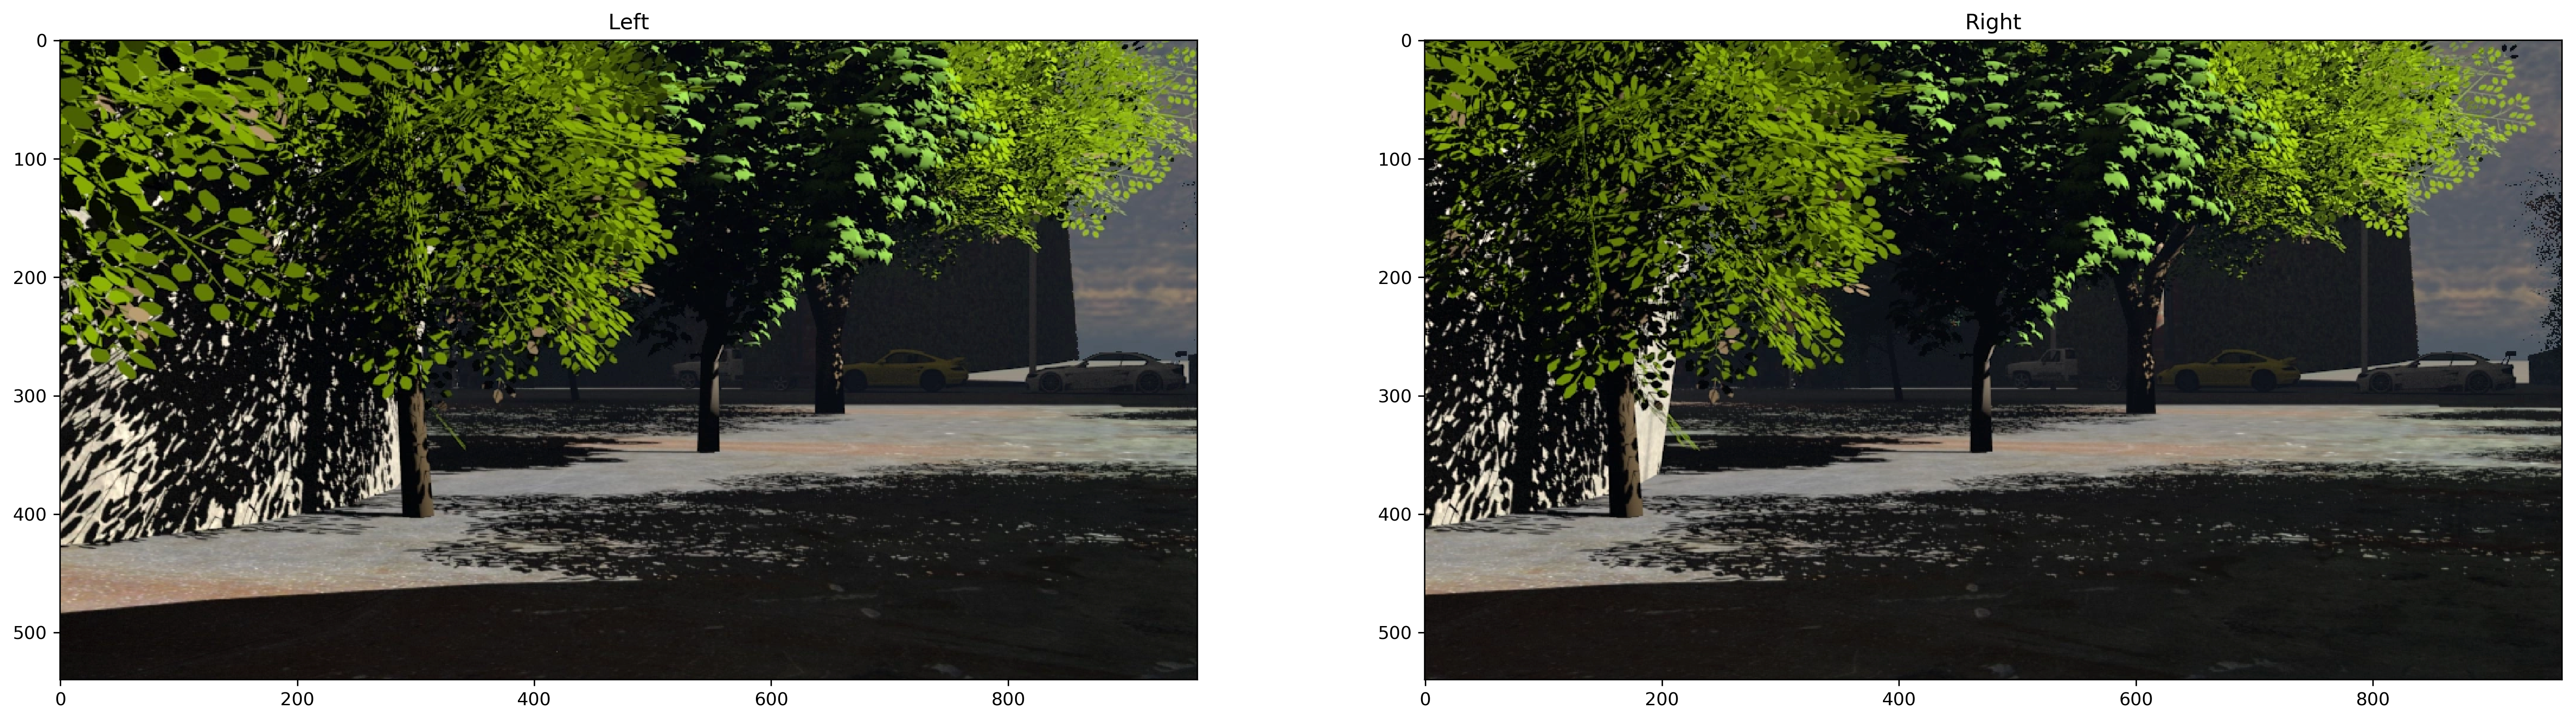

In [0]:
left_img = left_img.numpy().transpose((1,2,0))
right_img = right_img.numpy().transpose((1,2,0))


plt.figure(num=None, figsize=(25,10),dpi=300)
plt.subplot(121)
plt.imshow((left_img+1)/2)
plt.title("Left")

plt.subplot(122)
plt.imshow((right_img+1)/2)
plt.title("Right")

Text(0.5,1,'Pred - disp')

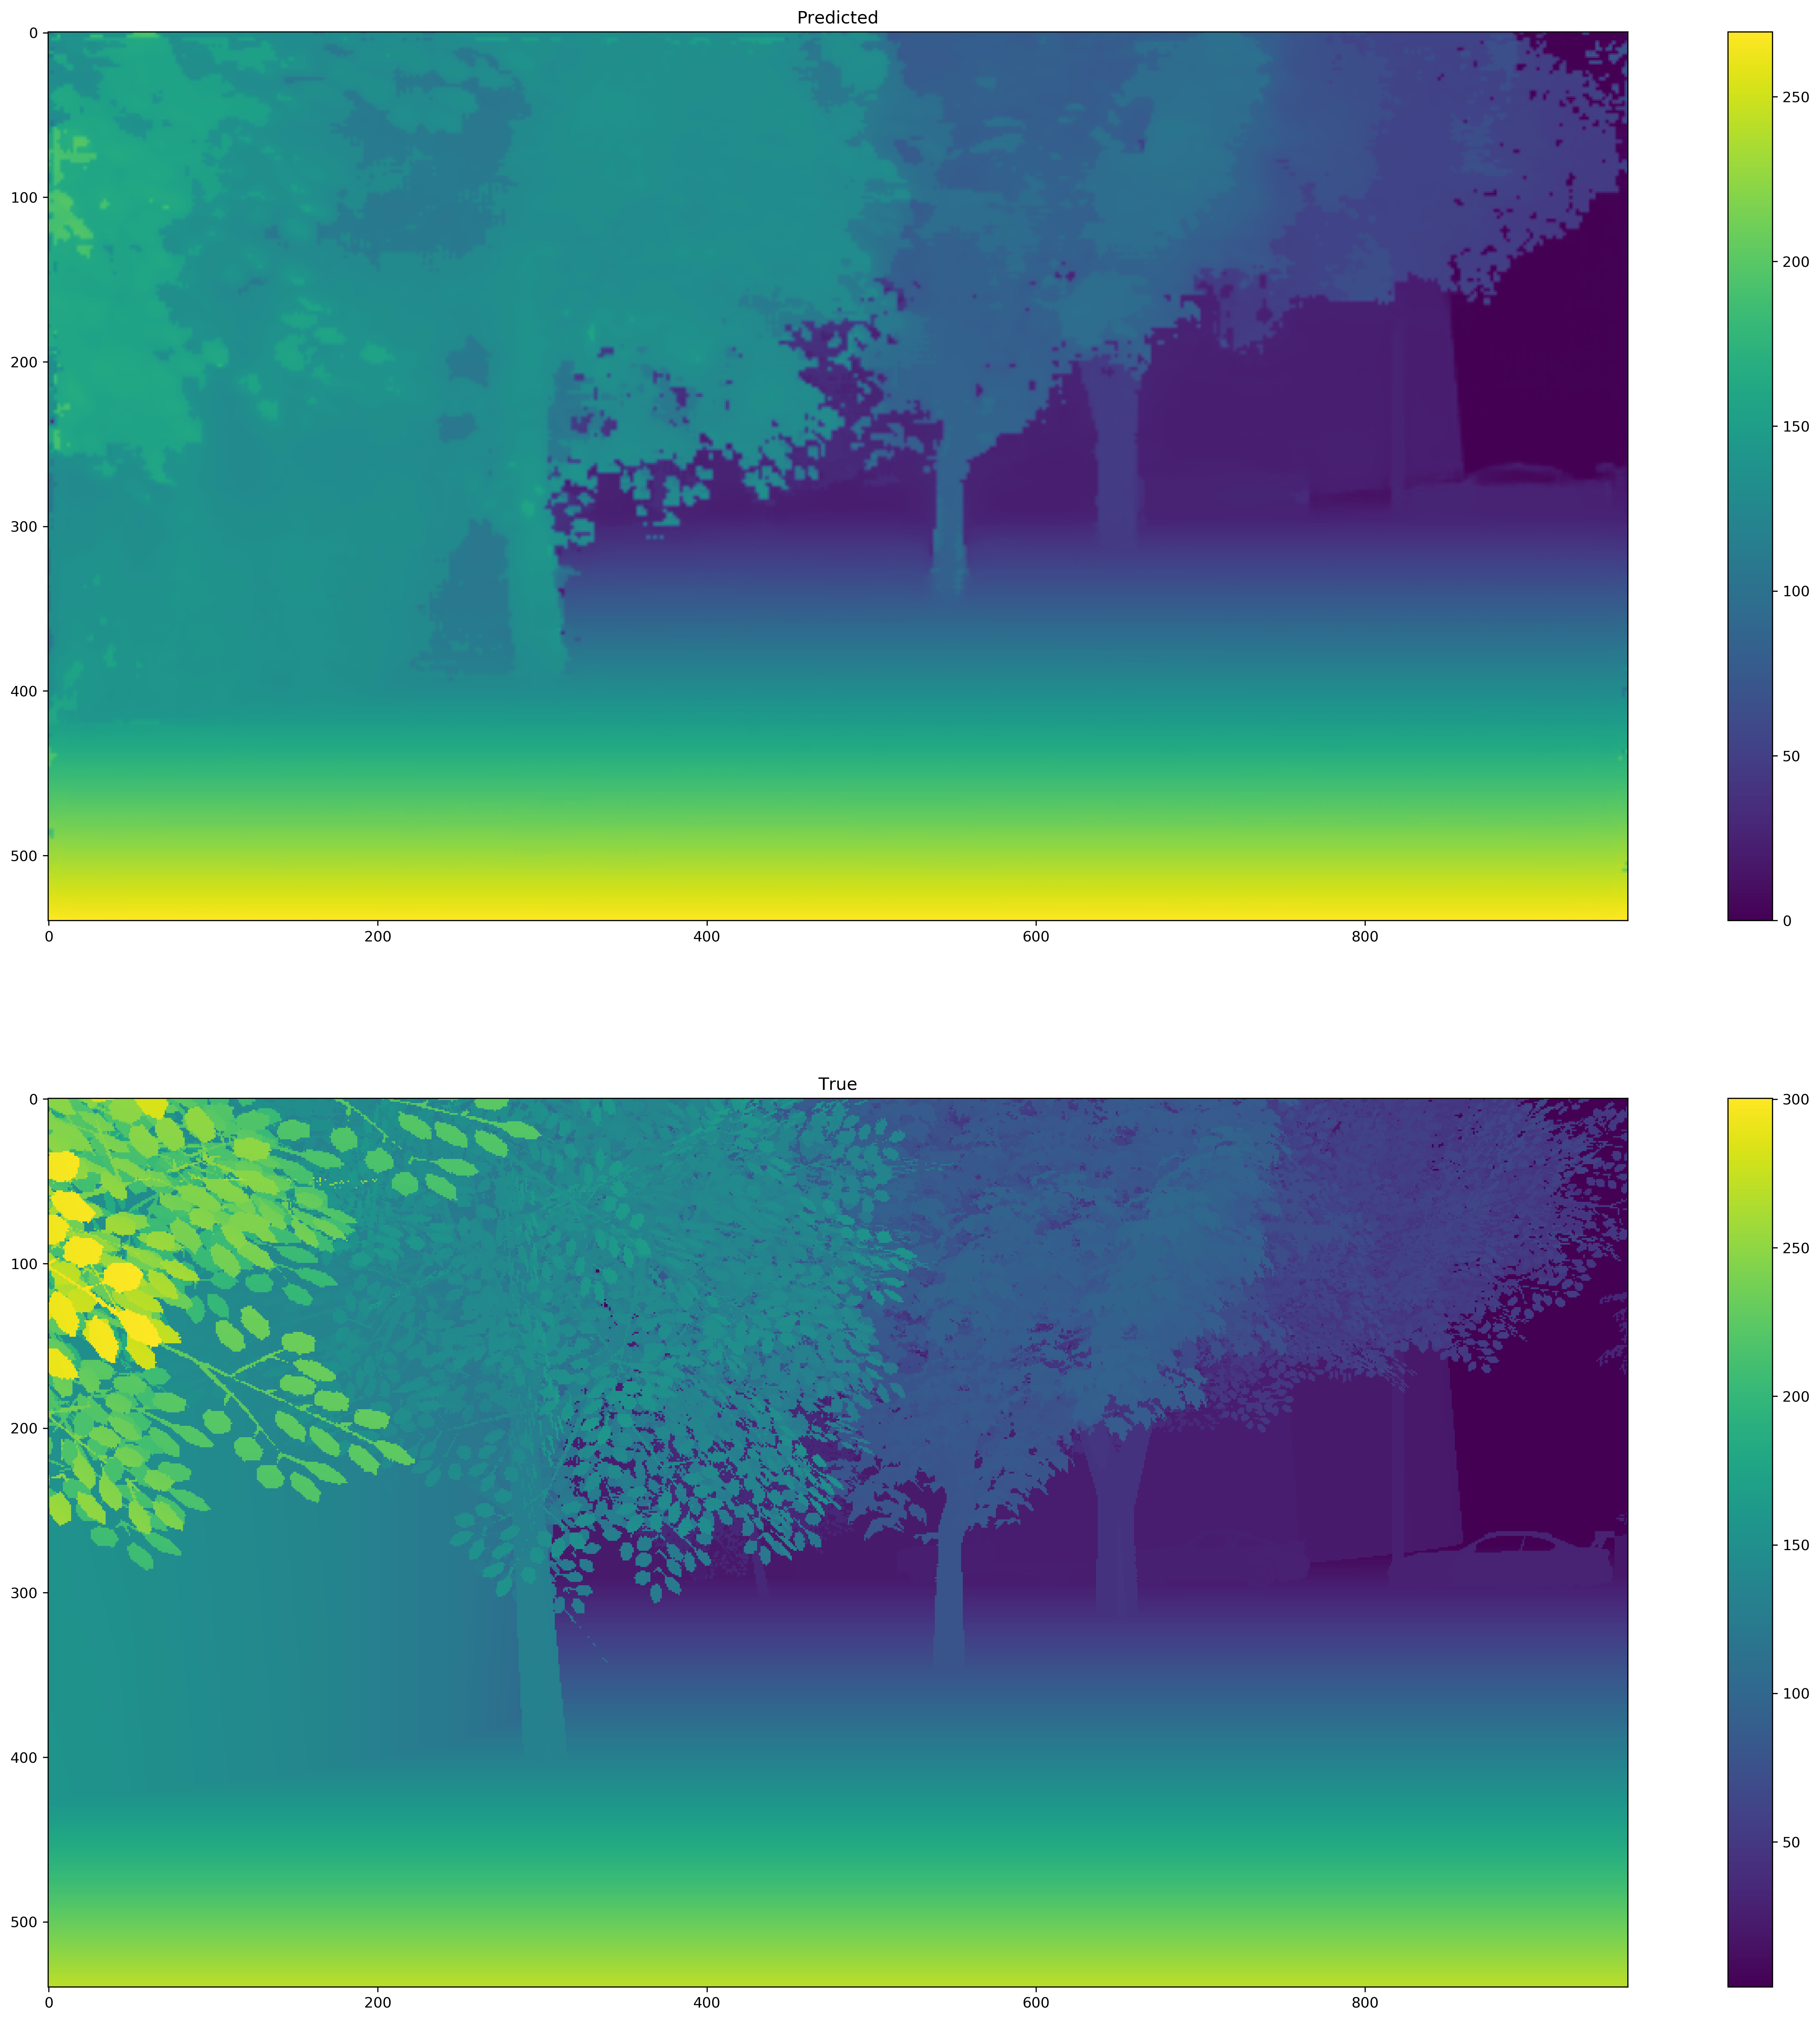

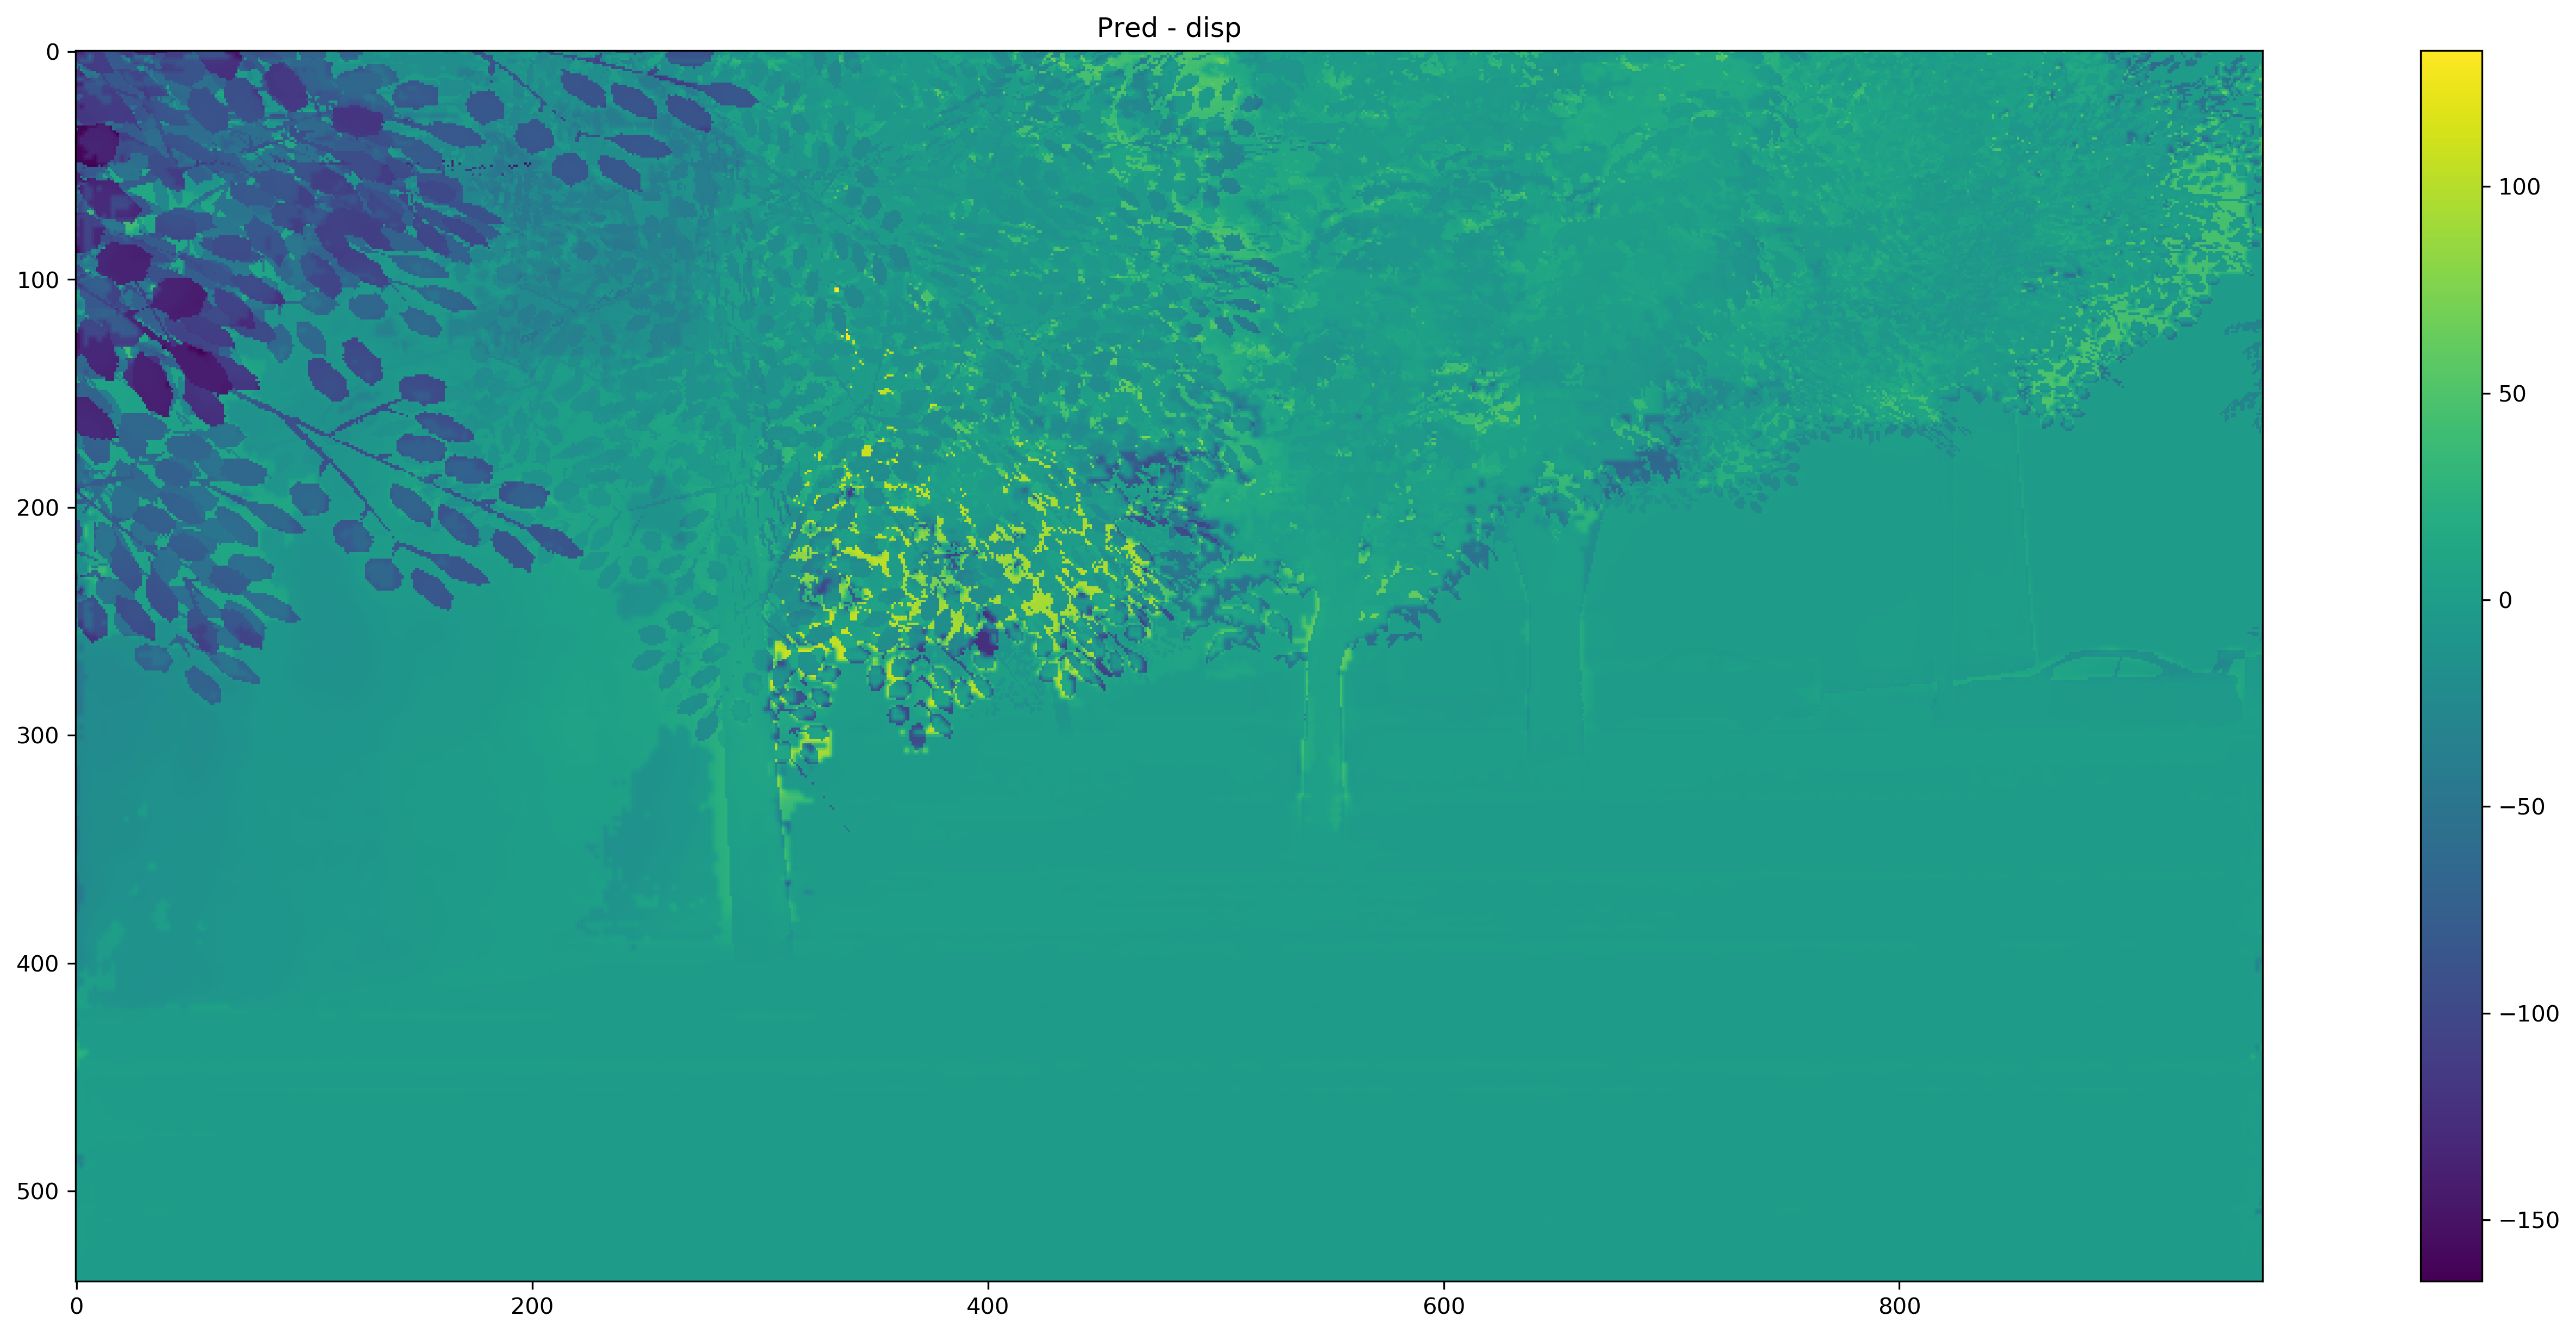

In [0]:
pred_disp = disp0.data.cpu().numpy()[0,0,:,:]
plt.figure(num=None, figsize=(25,25),dpi=300)
plt.subplot(211)
plt.imshow(pred_disp)
plt.title("Predicted")
plt.colorbar()
plt.subplot(212)
plt.imshow(disp_map0)
plt.colorbar()
plt.title("True")

plt.figure(num=None, figsize=(25,10),dpi=300)
plt.imshow(pred_disp-disp_map0)
plt.colorbar()
plt.title("Pred - disp")

In [0]:
# for param in seg_net.parameters():
#     l1(param,torch.zeros_like(param))

In [0]:
np.concatenate((left_img, right_img), 0).shape

(6, 540, 960)

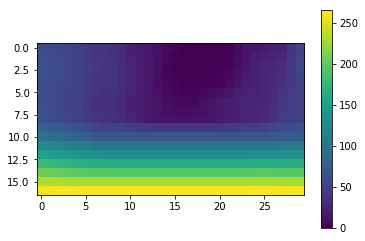

In [0]:
pred_disp = disp6.data.cpu().numpy()[0,0,:,:]
plt.imshow(pred_disp)
plt.colorbar()

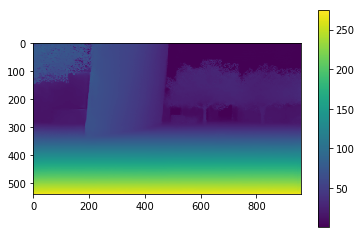

In [0]:
pred_disp = disp0.data.cpu().numpy().reshape((540, 960))
plt.imshow(pred_disp)
plt.colorbar()